# Triton Puzzle 6: Softmax Attention

Welcome to the sixth Triton puzzle! Attention is the cornerstone of modern transformers. This puzzle teaches you how to implement the scaled dot-product attention mechanism efficiently.

### What you'll learn:
- **Multi-stage computation** with multiple matrix operations
- **2D softmax** across sequence dimension
- **Causal masking** for autoregressive models
- **Memory-efficient attention** for long sequences
- **Numerical stability** with proper scaling
- Introduction to ideas behind **Flash Attention**

## Mathematical Background

Scaled dot-product attention computes:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(Q K^\top / \sqrt{d} \right) V
$$

Where: $Q, K, V \in \mathbb{R}^{B \times H \times N \times d}$, with B = batch size, H = number of heads, N = sequence length, d = head size.

### The Challenge

Standard attention has $O(N^2)$ memory complexity:
1. Compute scores: $S = Q K^\top$, a (B x H x N x N) tensor
2. Apply softmax: $P = \text{softmax}(S)$, still (B x H x N x N)
3. Compute output: $O = PV$, with (B x H x N x d_v)

For long sequences, the N x N attention matrix becomes prohibitive!


### Flash Attention Insight

Instead of materializing the full N x N attention matrix:
- Process attention in blocks
- Recompute rather than store intermediate values
- Use online softmax for numerical stability and faster computation

💡 Final Tip: Remember that you can use `TRITON_INTERPRET=1` to debug your kernels.

In [1]:
# To debug a kernel, uncomment this line and restart the kernel
# %env TRITON_INTERPRET=1

In [2]:
import os
import torch
import triton
import triton.language as tl
import numpy as np
from IPython.display import Image, display
import matplotlib.pyplot as plt

DEVICE = 'cpu' if os.environ.get('TRITON_INTERPRET', '0') == '1' else torch.device(f'cuda:{torch.cuda.current_device()}')
print(f"Using device: {DEVICE}")

# Set random seed
torch.manual_seed(42)

Using device: cuda:0


## Implementation 1: Naive PyTorch

First, let's see the standard implementation:

In [3]:
def attention_naive(Q, K, V, causal=False):
    """
    Naive attention implementation.
    Creates the full N×N attention matrix.
    
    Args:
        Q, K, V: (B, H, N, d) tensors
        causal: whether to apply causal mask
    """
    B, H, N, d = Q.shape
    
    # Compute attention scores
    scores = torch.matmul(Q, K.transpose(-2, -1)) / (d ** 0.5)  # (B, H, N, N)
    
    # Apply causal mask if needed
    if causal:
        mask = torch.triu(torch.ones(N, N, device=Q.device), diagonal=1).bool()
        scores.masked_fill_(mask, float('-inf'))
    
    # Apply softmax
    attn_weights = torch.softmax(scores, dim=-1)  # (B, H, N, N)
    
    # Compute output
    out = torch.matmul(attn_weights, V)  # (B, H, N, d)
    
    return out

## Implementation 2: PyTorch Built-in

PyTorch's scaled_dot_product_attention (introduced in PyTorch 2.0):

In [4]:
def attention_pytorch(Q, K, V, causal=False):
    """PyTorch's built-in attention (uses Flash Attention when possible)."""
    # Note: PyTorch expects (B, H, N, d) format
    return torch.nn.functional.scaled_dot_product_attention(
        Q, K, V, 
        is_causal=causal,
        dropout_p=0.0
    )

## Implementation 3: PyTorch Compiled



In [5]:
@torch.compile
def attention_compiled(Q, K, V, causal=False):
    """Compiled attention."""
    B, H, N, d = Q.shape
    scores = torch.matmul(Q, K.transpose(-2, -1)) / (d ** 0.5)
    if causal:
        mask = torch.triu(torch.ones(N, N, device=Q.device), diagonal=1).bool()
        scores.masked_fill_(mask, float('-inf'))
    attn_weights = torch.softmax(scores, dim=-1)
    out = torch.matmul(attn_weights, V)
    return out

## Key Concepts for This Puzzle

### 1. Block Processing Strategy

Instead of computing the full attention matrix:
```python
# Naive: O(N^2) memory
scores = Q @ K.T  # N×N matrix

# Block-wise: O(N) memory
for block_q in Q_blocks:
    for block_k in K_blocks:
        block_scores = block_q @ block_k.T  # Bq x Bk matrix
        # Process block...
```

### 2. Online Softmax for 2D

Extending our 1D online softmax to 2D:
- Each query attends to all keys
- Need to track max and sum for each query
- Update statistics as we process key blocks

### 3. Causal Masking

For autoregressive models:
- Query at position _i_ can only attend to positions _[1, ..., i]_
- Implement efficiently without creating full mask matrix

### 4. Memory vs Recomputation Trade-off

- Standard: Store N x N attention matrix
- Memory-efficient: Recompute blocks as needed
- Flash Attention: Never materialize full attention matrix

## Implementation 4: Triton Kernel (Puzzle)

Now implement memory-efficient attention!

We'll start with a simpler version that still materializes attention weights (but processes in blocks), then show the full Flash Attention style approach.

### Version 1: Block-wise Attention (Starter)

In [21]:
@triton.jit
def attention_kernel_v1(
    Q_ptr, K_ptr, V_ptr, Out_ptr,
    B, H, N, d,
    scale,
    stride_qb, stride_qh, stride_qn, stride_qd,
    stride_kb, stride_kh, stride_kn, stride_kd,
    stride_vb, stride_vh, stride_vn, stride_vd,
    stride_ob, stride_oh, stride_on, stride_od,
    causal: tl.constexpr,
    BLOCK_N: tl.constexpr,
    BLOCK_D: tl.constexpr,
):
    """
    Simplified attention kernel - still computes full attention per query.
    Each program handles one (batch, head, query) combination.
    
    This version is easier to understand but less memory efficient.
    """
    # YOUR IMPLEMENTATION GOES HERE
    # This is more complex - see Algorithm 1 in https://arxiv.org/pdf/2307.08691
    # Hints:
    # 1. Get batch, head, and query indices from program ID
    # 2. Load the query vector (size d)
    # 3. Loop over all keys to compute attention scores
    # 4. Apply softmax to get weights
    # 5. Use weights to compute weighted sum of values
    pass


def attention_triton_v1(Q, K, V, causal=False):
    """Wrapper for Triton attention kernel."""
    assert Q.shape == K.shape
    assert K.shape[-1] == V.shape[-1]
    B, H, N, d = Q.shape
    scale = 1.0 / (d**0.5)
    
    # Allocate output
    Out = torch.empty_like(Q).contiguous()

    # Ensure contiguity
    Q = Q.contiguous()
    K = K.contiguous()
    V = V.contiguous()
    
    # Choose block sizes
    BLOCK_N = min(triton.next_power_of_2(N), 64)
    BLOCK_D = min(triton.next_power_of_2(d), 32)
    
    # Launch kernel (one program per batch, head, query)
    grid = (B * H * N,)
    
    attention_kernel_v1[grid](
        Q, K, V, Out,
        B, H, N, d,
        scale,
        Q.stride(0), Q.stride(1), Q.stride(2), Q.stride(3),
        K.stride(0), K.stride(1), K.stride(2), K.stride(3),
        V.stride(0), V.stride(1), V.stride(2), V.stride(3),
        Out.stride(0), Out.stride(1), Out.stride(2), Out.stride(3),
        causal,
        BLOCK_N, BLOCK_D,
    )
    
    return Out

### Version 2: Flash Attention Style (Advanced)

In [22]:
@triton.jit
def attention_kernel_v2(
    Q_ptr, K_ptr, V_ptr, Out_ptr,
    B, H, N, d,
    scale,
    stride_qb, stride_qh, stride_qn, stride_qd,
    stride_kb, stride_kh, stride_kn, stride_kd,
    stride_vb, stride_vh, stride_vn, stride_vd,
    stride_ob, stride_oh, stride_on, stride_od,
    causal: tl.constexpr,
    BLOCK_M: tl.constexpr,  # Block size for queries
    BLOCK_N: tl.constexpr,  # Block size for keys/values
    BLOCK_D: tl.constexpr,  # Block size for head dimension
):
    """
    Flash Attention style kernel - never materializes full attention.
    Each program handles a block of queries.
    
    Key insight: Use online softmax to avoid storing attention weights!
    """
    # YOUR IMPLEMENTATION GOES HERE
    # This is more complex - see Algorithm 1 in https://arxiv.org/pdf/2307.08691
    pass


def attention_triton_v2(Q, K, V, causal=False):
    """Flash Attention style implementation."""
    assert Q.shape == K.shape
    assert K.shape[-1] == V.shape[-1]
    B, H, N, d = Q.shape
    scale = 1.0 / (d**0.5)

    # Allocate output
    Out = torch.empty_like(Q).contiguous()

    # Ensure contiguity
    Q = Q.contiguous()
    K = K.contiguous()
    V = V.contiguous()
    
    # Block sizes
    BLOCK_M = min(triton.next_power_of_2(N), 64)
    BLOCK_N = min(triton.next_power_of_2(N), 64)
    BLOCK_D = min(triton.next_power_of_2(d), 32)
    
    grid = (triton.cdiv(N, BLOCK_M), B * H)
    
    attention_kernel_v2[grid](
        Q, K, V, Out,
        B, H, N, d,
        scale,
        Q.stride(0), Q.stride(1), Q.stride(2), Q.stride(3),
        K.stride(0), K.stride(1), K.stride(2), K.stride(3),
        V.stride(0), V.stride(1), V.stride(2), V.stride(3),
        Out.stride(0), Out.stride(1), Out.stride(2), Out.stride(3),
        causal,
        BLOCK_M, BLOCK_N, BLOCK_D,
    )

    return Out

## Solution (🧙 You shall not pass!)

### Version 1: Simple Block-wise Solution

In [23]:
@triton.jit
def attention_kernel_v1(
    Q_ptr, K_ptr, V_ptr, Out_ptr,
    B, H, N, d,
    scale,
    stride_qb, stride_qh, stride_qn, stride_qd,
    stride_kb, stride_kh, stride_kn, stride_kd,
    stride_vb, stride_vh, stride_vn, stride_vd,
    stride_ob, stride_oh, stride_on, stride_od,
    causal: tl.constexpr,
    BLOCK_N: tl.constexpr,
    BLOCK_D: tl.constexpr,
):
    """Simple attention kernel - one program per query."""
    # Get program ID and decode indices
    pid = tl.program_id(0)
    
    # Decode batch, head, and query indices
    query_idx = pid % N
    head_idx = (pid // N) % H
    batch_idx = pid // (N * H)
    
    # Pointers to Q[batch, head, query, :]
    Q_ptr += batch_idx * stride_qb + head_idx * stride_qh + query_idx * stride_qn
    
    # Pointers to K[batch, head, :, :] and V[batch, head, :, :]
    K_ptr += batch_idx * stride_kb + head_idx * stride_kh
    V_ptr += batch_idx * stride_vb + head_idx * stride_vh
    
    # Output pointer
    Out_ptr += batch_idx * stride_ob + head_idx * stride_oh + query_idx * stride_on
    
    # Load query vector
    offs_d = tl.arange(0, BLOCK_D)
    mask_d = offs_d < d
    q = tl.load(Q_ptr + offs_d * stride_qd, mask=mask_d, other=0.0)
    
    # Initialize max and sum for online softmax
    max_score = -float('inf')
    sum_exp = 0.0
    
    # Initialize output accumulator
    acc = tl.zeros((BLOCK_D,), dtype=tl.float32)
    
    # First pass: compute softmax statistics
    for start_n in range(0, N, BLOCK_N):
        offs_n = start_n + tl.arange(0, BLOCK_N)
        mask_n = offs_n < N
        
        # Causal mask
        if causal:
            mask_n = mask_n & (offs_n <= query_idx)
        
        # Load keys [BLOCK_N, d]
        k_ptrs = K_ptr + offs_n[:, None] * stride_kn + offs_d[None, :] * stride_kd
        k = tl.load(k_ptrs, mask=mask_n[:, None] & mask_d[None, :], other=0.0)
        
        # Compute scores for this block
        scores = tl.sum(q[None, :] * k, axis=1) * scale  # [BLOCK_N]
        
        # Apply mask
        scores = tl.where(mask_n, scores, -float('inf'))
        
        # Update max
        block_max = tl.max(scores, axis=0)
        max_score = tl.maximum(max_score, block_max)
    
    # Second pass: compute attention weights and output
    for start_n in range(0, N, BLOCK_N):
        offs_n = start_n + tl.arange(0, BLOCK_N)
        mask_n = offs_n < N
        
        # Causal mask
        if causal:
            mask_n = mask_n & (offs_n <= query_idx)
        
        # Recompute keys and scores
        k_ptrs = K_ptr + offs_n[:, None] * stride_kn + offs_d[None, :] * stride_kd
        k = tl.load(k_ptrs, mask=mask_n[:, None] & mask_d[None, :], other=0.0)
        scores = tl.sum(q[None, :] * k, axis=1) * scale
        scores = tl.where(mask_n, scores, -float('inf'))
        
        # Compute exp(scores - max)
        exp_scores = tl.exp(scores - max_score)
        exp_scores = tl.where(mask_n, exp_scores, 0.0)
        sum_exp += tl.sum(exp_scores)
        
    # Third pass: compute weighted sum
    for start_n in range(0, N, BLOCK_N):
        offs_n = start_n + tl.arange(0, BLOCK_N)
        mask_n = offs_n < N
        
        # Causal mask
        if causal:
            mask_n = mask_n & (offs_n <= query_idx)
        
        # Recompute keys and scores (yes, again!)
        k_ptrs = K_ptr + offs_n[:, None] * stride_kn + offs_d[None, :] * stride_kd
        k = tl.load(k_ptrs, mask=mask_n[:, None] & mask_d[None, :], other=0.0)
        scores = tl.sum(q[None, :] * k, axis=1) * scale
        scores = tl.where(mask_n, scores, -float('inf'))
        
        # Compute attention weights
        weights = tl.exp(scores - max_score) / sum_exp
        weights = tl.where(mask_n, weights, 0.0)
        
        # Load values
        v_ptrs = V_ptr + offs_n[:, None] * stride_vn + offs_d[None, :] * stride_vd
        v = tl.load(v_ptrs, mask=mask_n[:, None] & mask_d[None, :], other=0.0)
        
        # Accumulate weighted values
        acc += tl.sum(weights[:, None] * v, axis=0)
    
    # Store output
    tl.store(Out_ptr + offs_d * stride_od, acc, mask=mask_d)

### Version 2: Flash Attention Style (Advanced)

In [24]:
@triton.jit
def attention_kernel_v2(
    Q_ptr, K_ptr, V_ptr, Out_ptr,
    B, H, N, d,
    scale,
    stride_qb, stride_qh, stride_qn, stride_qd,
    stride_kb, stride_kh, stride_kn, stride_kd,
    stride_vb, stride_vh, stride_vn, stride_vd,
    stride_ob, stride_oh, stride_on, stride_od,
    causal: tl.constexpr,
    BLOCK_M: tl.constexpr,
    BLOCK_N: tl.constexpr,
    BLOCK_D: tl.constexpr,
):
    """
    Flash Attention style - each program handles BLOCK_M queries.
    Uses online softmax to never materialize full attention.
    """
    # Program ID
    pid_m = tl.program_id(0)
    pid_bh = tl.program_id(1)
    
    # Decode batch and head
    batch_idx = pid_bh // H
    head_idx = pid_bh % H
    
    # Query block this program handles
    offs_m = pid_m * BLOCK_M + tl.arange(0, BLOCK_M)
    offs_d = tl.arange(0, BLOCK_D)
    
    # Initialize pointers
    Q_block_ptr = Q_ptr + batch_idx * stride_qb + head_idx * stride_qh
    K_block_ptr = K_ptr + batch_idx * stride_kb + head_idx * stride_kh  
    V_block_ptr = V_ptr + batch_idx * stride_vb + head_idx * stride_vh
    O_block_ptr = Out_ptr + batch_idx * stride_ob + head_idx * stride_oh
    
    # Load queries [BLOCK_M, d]
    mask_m = offs_m < N
    q_ptrs = Q_block_ptr + offs_m[:, None] * stride_qn + offs_d[None, :] * stride_qd
    q = tl.load(q_ptrs, mask=mask_m[:, None] & (offs_d[None, :] < d), other=0.0)
    
    # Initialize online softmax stats and output
    m_i = tl.full([BLOCK_M], value=-float('inf'), dtype=tl.float32)
    l_i = tl.zeros([BLOCK_M], dtype=tl.float32)
    acc = tl.zeros([BLOCK_M, BLOCK_D], dtype=tl.float32)
    
    # Loop over key/value blocks
    for start_n in range(0, N, BLOCK_N):
        offs_n = start_n + tl.arange(0, BLOCK_N)
        
        # Load keys and values
        k_ptrs = K_block_ptr + offs_n[None, :] * stride_kn + offs_d[:, None] * stride_kd
        v_ptrs = V_block_ptr + offs_n[:, None] * stride_vn + offs_d[None, :] * stride_vd
        
        mask_n = offs_n < N
        k = tl.load(k_ptrs, mask=(offs_d[:, None] < d) & mask_n[None, :], other=0.0)
        
        # Compute scores [BLOCK_M, BLOCK_N]
        scores = tl.dot(q, k, out_dtype=tl.float32) * scale
        
        # Causal mask
        if causal:
            mask_causal = offs_m[:, None] >= offs_n[None, :]
            scores = tl.where(mask_causal & mask_n[None, :], scores, -float('inf'))
        else:
            scores = tl.where(mask_n[None, :], scores, -float('inf'))
        
        # Online softmax update
        m_ij = tl.max(scores, axis=1)  # [BLOCK_M]
        m_i_new = tl.maximum(m_i, m_ij)
        
        # Compute exponentials
        exp_scores = tl.exp(scores - m_i_new[:, None])
        l_ij = tl.sum(exp_scores, axis=1)
        
        # Update statistics
        alpha = tl.exp(m_i - m_i_new)
        l_i_new = alpha * l_i + l_ij
        
        # Load values
        v = tl.load(v_ptrs, mask=mask_n[:, None] & (offs_d[None, :] < d), other=0.0)
        
        # Update accumulator
        acc = acc * alpha[:, None] + tl.dot(exp_scores, v, out_dtype=tl.float32)
        
        # Update m_i and l_i for next iteration
        m_i = m_i_new
        l_i = l_i_new
    
    # Final output
    acc = acc / l_i[:, None]
    
    # Store
    o_ptrs = O_block_ptr + offs_m[:, None] * stride_on + offs_d[None, :] * stride_od
    tl.store(o_ptrs, acc, mask=mask_m[:, None] & (offs_d[None, :] < d))

## Testing Correctness

### Version 1

In [25]:
def test_attention(B=2, H=4, N=128, d=64, causal=False, atol=1e-2, rtol=1e-2):
    """Test attention implementation against PyTorch."""
    torch.manual_seed(42)
    
    # Generate random inputs
    Q = torch.randn(B, H, N, d, device=DEVICE, dtype=torch.float32)
    K = torch.randn(B, H, N, d, device=DEVICE, dtype=torch.float32)
    V = torch.randn(B, H, N, d, device=DEVICE, dtype=torch.float32)
    
    # PyTorch reference
    expected = attention_pytorch(Q, K, V, causal=causal)
    
    # Triton implementation
    actual = attention_triton_v1(Q, K, V, causal=causal)
    
    try:
        torch.testing.assert_close(actual, expected, atol=atol, rtol=rtol)
        print(f"✅ Test PASSED! ({'causal' if causal else 'non-causal'})")
        print(f"   Shape: (B={B}, H={H}, N={N}, d={d})")
        print(f"   Max error: {(actual - expected).abs().max().item():.2e}")
        return True
    except AssertionError as e:
        print(f"❌ Test FAILED!")
        print(f"   Error: {e}")
        return False

# Test both causal and non-causal
test_passed = test_attention(causal=False)
test_passed &= test_attention(causal=True)

# Display congrats message
if test_passed:
    print("\n🎉 Congratulations! Your implementation is correct!")
    display(Image("https://c.tenor.com/9d2wq28eb9UAAAAC/tenor.gif", width=256, height=256))

❌ Test FAILED!
   Error: Tensor-likes are not close!

Mismatched elements: 61723 / 65536 (94.2%)
Greatest absolute difference: 1.7254130840301514 at index (1, 1, 42, 35) (up to 0.01 allowed)
Greatest relative difference: 2158750.5 at index (1, 3, 69, 60) (up to 0.01 allowed)
❌ Test FAILED!
   Error: Tensor-likes are not close!

Mismatched elements: 62187 / 65536 (94.9%)
Greatest absolute difference: 4.584095001220703 at index (1, 2, 1, 50) (up to 0.01 allowed)
Greatest relative difference: 67639.6171875 at index (1, 1, 86, 41) (up to 0.01 allowed)


### Version 2

In [26]:
def test_attention(B=2, H=4, N=128, d=64, causal=False, atol=1e-2, rtol=1e-2):
    """Test attention implementation against PyTorch."""
    torch.manual_seed(42)
    
    # Generate random inputs
    Q = torch.randn(B, H, N, d, device=DEVICE, dtype=torch.float32)
    K = torch.randn(B, H, N, d, device=DEVICE, dtype=torch.float32)
    V = torch.randn(B, H, N, d, device=DEVICE, dtype=torch.float32)
    
    # PyTorch reference
    expected = attention_pytorch(Q, K, V, causal=causal)
    
    # Triton implementation
    actual = attention_triton_v2(Q, K, V, causal=causal)
    
    try:
        torch.testing.assert_close(actual, expected, atol=atol, rtol=rtol)
        print(f"✅ Test PASSED! ({'causal' if causal else 'non-causal'})")
        print(f"   Shape: (B={B}, H={H}, N={N}, d={d})")
        print(f"   Max error: {(actual - expected).abs().max().item():.2e}")
        return True
    except AssertionError as e:
        print(f"❌ Test FAILED!")
        print(f"   Error: {e}")
        return False

# Test both causal and non-causal
test_passed = test_attention(causal=False)
test_passed &= test_attention(causal=True)

# Display congrats message
if test_passed:
    print("\n🎉 Congratulations! Your implementation is correct!")
    display(Image("https://c.tenor.com/9d2wq28eb9UAAAAC/tenor.gif", width=256, height=256))

❌ Test FAILED!
   Error: Tensor-likes are not close!

Mismatched elements: 60347 / 65536 (92.1%)
Greatest absolute difference: 0.9342812895774841 at index (1, 1, 42, 50) (up to 0.01 allowed)
Greatest relative difference: 276318.875 at index (1, 3, 69, 60) (up to 0.01 allowed)
❌ Test FAILED!
   Error: Tensor-likes are not close!

Mismatched elements: 61901 / 65536 (94.5%)
Greatest absolute difference: 4.156162738800049 at index (1, 1, 26, 44) (up to 0.01 allowed)
Greatest relative difference: 101354.75 at index (1, 1, 86, 41) (up to 0.01 allowed)


## Performance Analysis

In [17]:
def analyze_attention(B, H, N, d):
    """Analyze memory and compute for attention."""
    element_size = 4  # float32
    
    # Standard attention
    standard = {
        'attention_matrix': B * H * N * N * element_size,  # Q @ K^T
        'total_memory': B * H * N * N * element_size + B * H * N * d * element_size,
    }
    
    # Flash attention (approximate)
    block_size = 128
    flash = {
        'working_memory': B * H * block_size * block_size * element_size,  # One block at a time
        'total_memory': B * H * block_size * block_size * element_size,
    }
    
    # Compute
    flops = B * H * (2 * N * N * d + 2 * N * N * d)  # Q@K^T + softmax@V
    
    return {
        'standard_memory': standard['total_memory'],
        'flash_memory': flash['total_memory'],
        'memory_reduction': standard['total_memory'] / flash['total_memory'],
        'flops': flops,
    }

# Example
B, H, N, d = 8, 16, 512, 64
analysis = analyze_attention(B, H, N, d)

print(f"Attention Analysis (B={B}, H={H}, N={N}, d={d}):")
print(f"  Standard memory: {analysis['standard_memory'] / 1e9:.2f} GB")
print(f"  Flash memory: {analysis['flash_memory'] / 1e6:.2f} MB")
print(f"  Memory reduction: {analysis['memory_reduction']:.0f}x")
print(f"  FLOPs: {analysis['flops'] / 1e9:.2f} GFLOPs")

Attention Analysis (B=8, H=16, N=512, d=64):
  Standard memory: 0.15 GB
  Flash memory: 8.39 MB
  Memory reduction: 18x
  FLOPs: 8.59 GFLOPs


## Benchmarking

Running benchmarks...


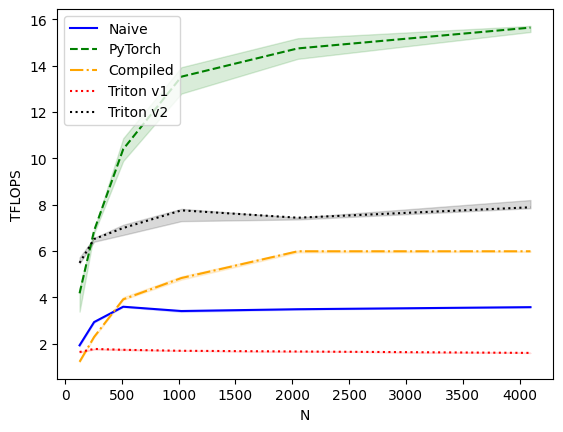

attention-performance:
        N     Naive    PyTorch  Compiled  Triton v1  Triton v2
0   128.0  1.927529   4.171362  1.215036   1.638400   5.486336
1   256.0  2.931030   6.878728  2.288374   1.771243   6.515424
2   512.0  3.592744  10.393196  3.910887   1.733094   6.990506
3  1024.0  3.407276  13.523538  4.830930   1.691188   7.752873
4  2048.0  3.485089  14.742720  5.986217   1.660319   7.434650
5  4096.0  3.574317  15.641269  5.986522   1.599551   7.884956


In [19]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # Sequence length
        x_vals=[128, 256, 512, 1024, 2048, 4096],  #, 8192, 16384, 32768, 65536],
        line_arg='provider',
        line_vals=['naive', 'pytorch', 'compiled', 'triton_v1', 'triton_v2'],
        line_names=['Naive', 'PyTorch', 'Compiled', 'Triton v1', 'Triton v2'],
        styles=[('blue', '-'), ('green', '--'), ('orange', '-.'), ('red', ':'), ('black', ':')],
        ylabel='TFLOPS',
        plot_name='attention-performance',
        args={'B': 4, 'H': 8, 'd': 64, 'causal': True},  # feel free to edit these values!
    )
)
def benchmark(N, B, H, d, causal, provider):
    """Benchmark attention implementations."""
    Q = torch.randn(B, H, N, d, device=DEVICE, dtype=torch.float32)
    K = torch.randn(B, H, N, d, device=DEVICE, dtype=torch.float32)
    V = torch.randn(B, H, N, d, device=DEVICE, dtype=torch.float32)
    
    # Normalize
    Q = Q / Q.norm(dim=-1, keepdim=True)
    K = K / K.norm(dim=-1, keepdim=True)
    
    quantiles = [0.5, 0.05, 0.95]
    
    if provider == 'naive':
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: attention_naive(Q, K, V, causal=causal), quantiles=quantiles
        )
    elif provider == 'pytorch':
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: attention_pytorch(Q, K, V, causal=causal), quantiles=quantiles
        )
    elif provider == 'compiled':
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: attention_compiled(Q, K, V, causal=causal), quantiles=quantiles
        )
    elif provider == 'triton_v1':
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: attention_triton_v1(Q, K, V, causal=causal), quantiles=quantiles
        )
    elif provider == 'triton_v2':
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: attention_triton_v2(Q, K, V, causal=causal), quantiles=quantiles
        )
    
    # Calculate FLOPS (approximate)
    flops = B * H * (2 * N * N * d + 2 * N * N * d)
    tflops = lambda ms: flops / ms / 1e9
    
    return tflops(ms), tflops(max_ms), tflops(min_ms)

print("Running benchmarks...")
results = benchmark.run(show_plots=True, print_data=True, return_df=True, save_path='')

## Speedup?

In [20]:
# Check if Triton is faster than PyTorch
avg_pytorch = results['PyTorch'].mean()
avg_triton = results['Triton v2'].mean()
speedup = avg_triton / avg_pytorch

if speedup > 1.0:
    print(f"\n🚀 Awesome! Triton is {speedup:.2f}x faster than PyTorch!")
    display(Image("https://c.tenor.com/QFFzqAIAvnIAAAAd/tenor.gif", width=400, height=256))
else:
    print(f"\n🐌🐌🐌 Triton implementation is {speedup:.2f}x slower than PyTorch!. 🐌🐌🐌")


🐌🐌🐌 Triton implementation is 0.64x slower than PyTorch!. 🐌🐌🐌


## Summary

You've successfully implemented the (forward pass) of Flash Attention - one of the cornerstone of modern AI!


### Performance Insights:

- **Memory bottleneck**: O(N²) attention matrix is the main constraint
- **Flash Attention**: Never materializing full attention saves massive memory
- **Recomputation**: Trading compute for memory is often worthwhile
- **Block sizes**: Critical for balancing parallelism and memory usage

### Real-World Impact:

- **Longer sequences**: Flash Attention enables processing much longer sequences
- **Larger models**: Memory savings allow bigger batch sizes
- **Energy efficiency**: Less memory movement = less energy consumption
- **Production ready**: These techniques power ChatGPT, Claude, and other LLMs!

### Advanced Extensions:

- **Multi-Query Attention (MQA)**: Share keys/values across heads
- **Grouped-Query Attention (GQA)**: Share keys/values across groups of heads
- **Sliding Window Attention**: Local attention patterns
- **Sparse Attention**: Attend to specific positions only

### What's Next?

You have one final challenge: Sparsemax Attention! Let's do it!

<img src="sardine-super-flash.png" width="800" />